# Calibration notebook

About this notebook, we've divided it into the 4 following parts:

1. **Predictions loading**: We load a CSV file with the predictions concerning the model to evaluate.
2. **Evaluations loading**: We load a CSV file with the evaluations concerning the model to evaluate.
3. **Calibrator fit**: After specifying the target measure of interest (e.g., f1-score, accuracy), we fit some calibration models to the transformed predictions using the aforementioned predictions. This introduces some limitations in terms of the granularity of the metrics -- are we fitting it into a discrete/categorical or continuous variable?
5. **Dump calibrated predictions** and **model**: After fitting the model we store the model checkpoint as well as its predictions in the specified folders.


**Note**: We assume that all of these files will have a set of index columns through which we can jointly align them.


In [1]:
OUTPUT_DIR = "../outputs"

# name of the dataset to preprocess
# DATASET_NAME, SPLIT_NAME = "squad", "validation"
DATASET_NAME, SPLIT_NAME = "newsqa", "dev"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'new_wiki'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'nyt'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'amazon'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'reddit'), "test"
# DATASET_NAME, SPLIT_NAME = "narrativeqa", "test_5k_sample_seed_2022"


IS_LOCAL_FS_DATASET = True \
    if (DATASET_NAME in ("newsqa", ) or SPLIT_NAME in ("test_5k_sample_seed_2022",)) \
    else False

if isinstance(DATASET_NAME, tuple):
    NORMALIZED_DATASET_NAME = "".join(DATASET_NAME)
else:
    NORMALIZED_DATASET_NAME = DATASET_NAME
    
# ---------------------------------------------------------------------------
# 
# ---------------------------------------------------------------------------
BASE_FILENAME = f"{NORMALIZED_DATASET_NAME}_{SPLIT_NAME}"
ROOT_DIR = f"{OUTPUT_DIR}/results/{NORMALIZED_DATASET_NAME}/{SPLIT_NAME}"

CALIB_ROOT_DIR = f"{ROOT_DIR}/calib"

# ---------------------------------------------------------------------------
# 
# ---------------------------------------------------------------------------

# Arguments used to read the files from disk
csv_kwargs = {
   "compression": "gzip",
   "encoding": "utf-8",
}
    
# ---------------------------------------------------------------------------
# Data columns
# ---------------------------------------------------------------------------
ID_COLS = ["example_id", "answer_id"]
UNIQUE_ID_COL = ID_COLS[0]

## (optional) Split the matrix in calibration and test set

If you dont need this step, feel free to skip this section.

In [2]:
from sklearn.model_selection import train_test_split

import pandas as pd

In [3]:
SPLIT_SEED = 9182
HOLDOUT_FRACTION = 0.5 

# --------------------------------------------------------------------------------
# Original matrices that we're departing to create the two sets for calibration:
# --------------------------------------------------------------------------------
PREDS_DIR = f"{ROOT_DIR}/preds"
PREDS_FILENAME = f"{NORMALIZED_DATASET_NAME}_{SPLIT_NAME}_scores"
PREDS_FILEPATH = f"{PREDS_DIR}/{BASE_FILENAME}_{PREDS_FILENAME}.csv.gz"
# PREDS_FILEPATH = f"{PREDS_DIR}/{BASE_FILENAME}" + f"_{DATASET_NAME}_{SPLIT_NAME}.csv.gz"
#^Note: Typically we'll want the version of the predictions file that has the
# different normalization scores (identified by suffix "_scores")

EVALS_TOKENIZER = "default"
EVALS_DIR = f"{ROOT_DIR}/evals"
EVALS_FILENAME = f"{BASE_FILENAME}_evals_{EVALS_TOKENIZER}"
EVALS_FILEPATH = f"{EVALS_DIR}/{EVALS_FILENAME}.csv.gz"

preds = pd.read_csv(PREDS_FILEPATH, **csv_kwargs).set_index(UNIQUE_ID_COL)
evals = pd.read_csv(EVALS_FILEPATH, **csv_kwargs).set_index(UNIQUE_ID_COL)

print(len(preds), len(evals))
# In the future we may have dimension mismatch between the evals and preds
# (e.g., multiple beams) requiring some joining process. For now, keeping things
# simple, we'll create the splits based on the UNIQUE_ID_COL to ensure there is
# **no label leakage**, i.e., since the prediction is the same for multiple answer
# pairs, naively sampling them would cause our estimates in the test set to be
# optimistic and not representative of what's going on.
common_examples = preds.index.intersection(evals.index)

calibration_set, test_set = train_test_split(
    common_examples, test_size=HOLDOUT_FRACTION, random_state=SPLIT_SEED)
print("Calibration set size:", len(calibration_set), "\tTest set size:", len(test_set))

calib_preds, calib_evals = preds.loc[calibration_set,:], evals.loc[calibration_set,:]
test_preds, test_evals = preds.loc[test_set,:], evals.loc[test_set,:]

# Sanity check that we have the same exact columns in both sets
assert all([c_col == t_col for c_col, t_col in zip(calib_preds.columns, test_preds.columns)])
assert all([c_col == t_col for c_col, t_col in zip(calib_evals.columns, test_evals.columns)])

4341 4340
Calibration set size: 2170 	Test set size: 2170


We will now write these to a new directory under `{CALIB_DIR}/matrix` not to be mixed with the original dataset preprocessed matrices.

In [4]:
CALIBRATION_MATRIX_DIR = f"{CALIB_ROOT_DIR}/matrix"
!mkdir -p {CALIBRATION_MATRIX_DIR}

# Create trainin set predictions
calib_preds.to_csv(f"{CALIBRATION_MATRIX_DIR}/train_{PREDS_FILENAME}.csv.gz", **csv_kwargs)
test_preds.to_csv(f"{CALIBRATION_MATRIX_DIR}/test_{PREDS_FILENAME}.csv.gz", **csv_kwargs)

calib_evals.to_csv(f"{CALIBRATION_MATRIX_DIR}/train_{EVALS_FILENAME}.csv.gz", **csv_kwargs)
test_evals.to_csv(f"{CALIBRATION_MATRIX_DIR}/test_{EVALS_FILENAME}.csv.gz", **csv_kwargs)

## Fit calibration

In [5]:
import pandas as pd
import numpy as np


def get_dataset_for_calibration(preds_path, evals_path, features, target, id_cols, **csv_kwargs):
    print("Loading predictions from", preds_path)
    print("Loading evaluation metrics from", evals_path)
    
    preds = pd.read_csv(preds_path, **csv_kwargs).set_index(id_cols)
    evals = pd.read_csv(evals_path, **csv_kwargs).set_index(id_cols)
    
    # Even though we have an evaluation for each instance in the dataset
    # the predictions are not duplicated across different data points
    # hence requiring some filtering to make the two matrices of the same size.
    _evals_cols = evals.columns
    evals  = preds.join(evals, how="left")[_evals_cols]
    assert len(preds) == len(evals)
    
    
    print("Considering features:", features)
    print("Considering target:", target)
    return preds[features], evals[target]

### Calibration inputs

In [6]:
TRAIN_SET_PREDS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/train_{PREDS_FILENAME}.csv.gz"
TEST_SET_PREDS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/test_{PREDS_FILENAME}.csv.gz"

TRAIN_SET_EVALS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/train_{EVALS_FILENAME}.csv.gz"
TEST_SET_EVALS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/test_{EVALS_FILENAME}.csv.gz"

# The name of the feature in the target that we're trying to calibrate towards
UNCALIBRATED_SCORE_COLS = [
    "score_proba",
    "score_proba_arithm",
    "score_proba_geom",
    "score_proba_hmean",
    "score_proba_std",
]

# The metric we're calibrating w.r.t.
CALIBRATION_TARGET = "f1_score"

ID_COLS = ["example_id", "answer_id"]

## Predictions & Evaluations loading

In [7]:
X_train, y_train = get_dataset_for_calibration(
    TRAIN_SET_PREDS_FILEPATH, TRAIN_SET_EVALS_FILEPATH, 
    features=UNCALIBRATED_SCORE_COLS,
    target=CALIBRATION_TARGET,
    id_cols=ID_COLS,
    **csv_kwargs,
)

Loading predictions from ../outputs/results/newsqa/dev/calib/matrix/train_newsqa_dev_scores.csv.gz
Loading evaluation metrics from ../outputs/results/newsqa/dev/calib/matrix/train_newsqa_dev_evals_default.csv.gz
Considering features: ['score_proba', 'score_proba_arithm', 'score_proba_geom', 'score_proba_hmean', 'score_proba_std']
Considering target: f1_score


In [8]:
X_train.head()

,,score_proba,score_proba_arithm,score_proba_geom,score_proba_hmean,score_proba_std
example_id,answer_id,,,,,
719,f48834ad272adf1a76dd6d08ba9f64f4,0.711631,0.939657,0.934224,0.928246,0.096005
3555,0029119384501947070f360116170f59,0.868205,0.980567,0.980013,0.979441,0.032437
2672,9c23c8194813c2733ef4f499e730da06,0.181367,0.776973,0.652589,0.493306,0.335388
1684,b2b76c091742db80ed3bfcaaf2f498ba,0.789214,0.947141,0.942538,0.937589,0.089764
630,47064b1b0ae4a5443792e50548ddeb9b,0.403432,0.816448,0.796971,0.777961,0.177276


## Calibration methods

In this section, we're running logistic regression calibration and beta regression calibration techniques to fit a monotonic curve to map from the provided data to the specified one.

In [9]:
import matplotlib.pyplot as plt
import ml_insights as mli

import seaborn as sns

About the plot:
- Length of the acceptance intervals gets larger as we have less data points.
- Ideal: have good calibration across all areas -- (awful result is to have good calibration in rare regions).
- If too little data - may consider merging bins. I'm not confident that this will is useful for NLP in practice.

In [10]:
mli_reliability_kwargs = {
    "ax1_y_title": f"true {CALIBRATION_TARGET}",
    "error_bars": False,
    "show_histogram": True,
}

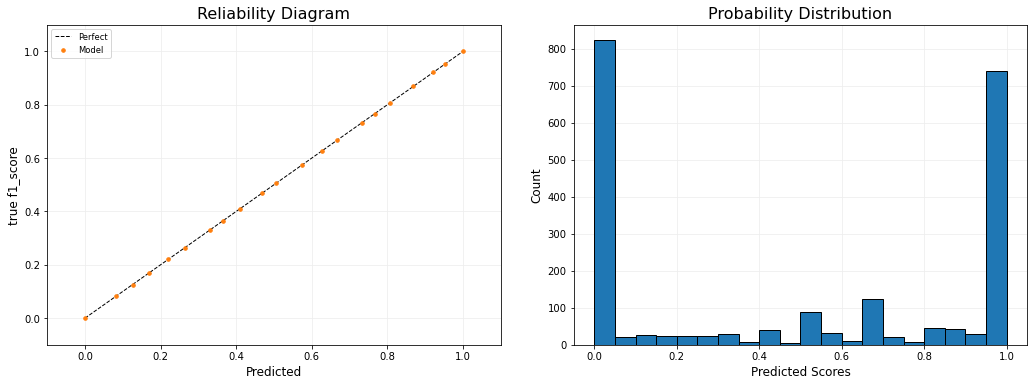

In [11]:
# Distribution of the f1 scores
plt.figure(figsize=(15, 6)); mli.plot_reliability_diagram(y=y_train, x=y_train, **mli_reliability_kwargs);

###  Before calibration

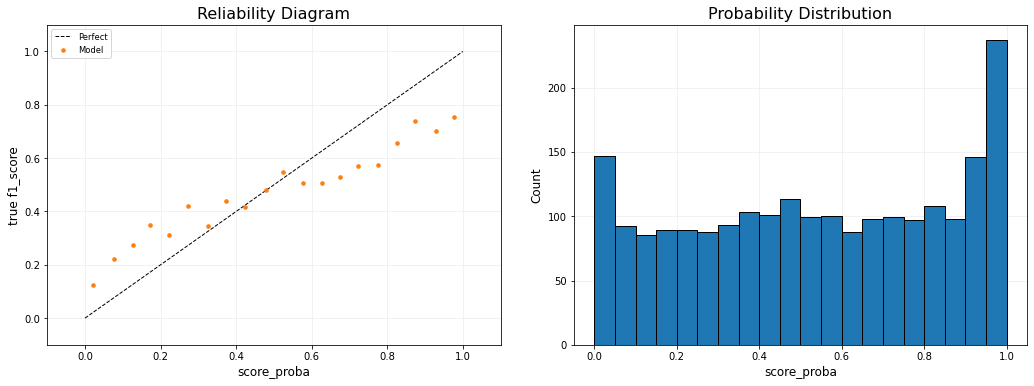

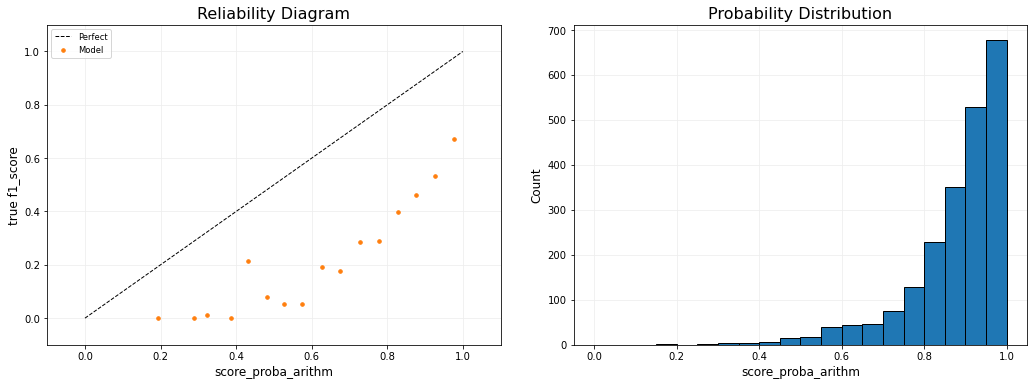

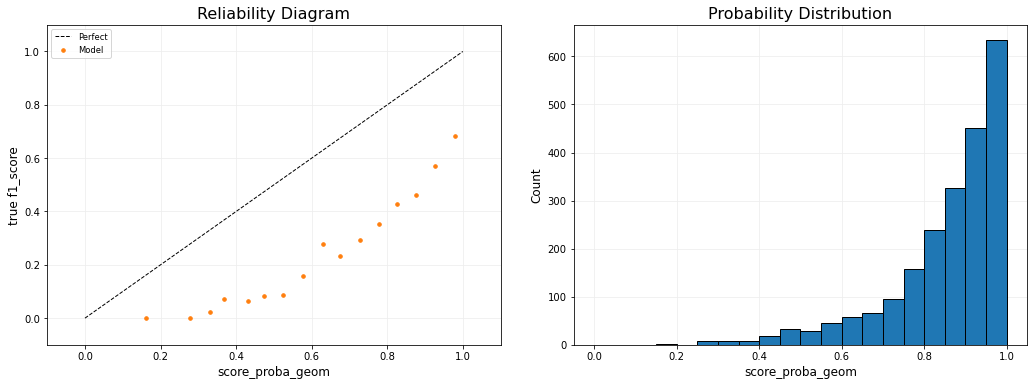

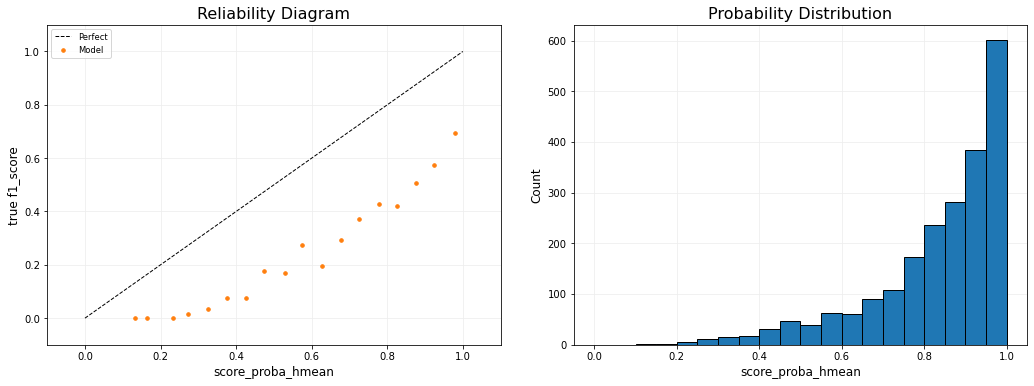

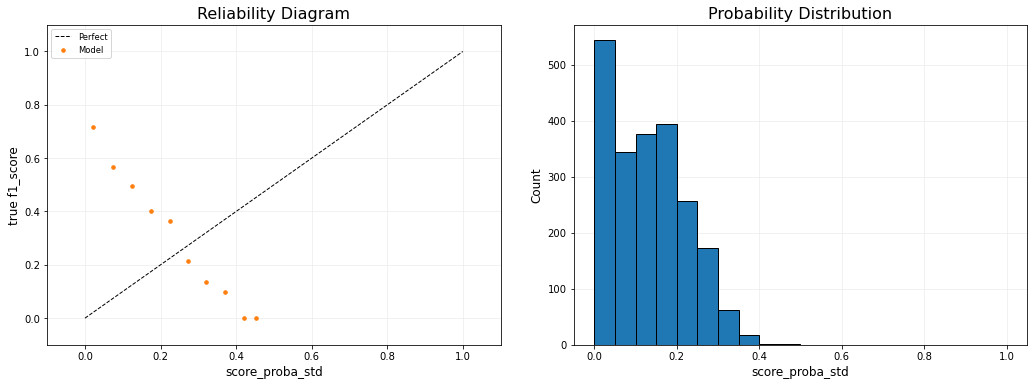

In [12]:
for col in UNCALIBRATED_SCORE_COLS:
    col_kwargs = mli_reliability_kwargs.copy()
    col_kwargs.update({
        "ax1_y_title": f"true {CALIBRATION_TARGET}",
        "ax1_x_title": f"{col}",
        "ax2_x_title": f"{col}",
    })
    # Uncalibrated and calibrated values
    x = X_train[col]
    plt.figure(figsize=(15, 6));
    mli.plot_reliability_diagram(y=y_train, x=x, **col_kwargs);

### Logistic Regression (continuous version) w/ MSE

In [13]:
def fit_model(X, y, col, target, model_classpath, model_hyperparams, figname):
    model = model_classpath(**model_hyperparams)
    
    assert len(X.shape) == 1 and len(y.shape) == 1, "This is a 1-d logistic fit"
    model.fit(X, y)
    
    # -------------------------------------------------------------------
    # Observe the fit
    # -------------------------------------------------------------------
    # We re-use the same structure as the preds we've loaded initially
    # write them into a calibrated predictions file.
    g = sns.jointplot(x=X, y=y)
    g.ax_joint.set_xlabel(col)
    g.ax_joint.set_ylabel(target)
    # Plot decision boundary
    tvec = np.linspace(.01, .99, 99)
    sns.lineplot(tvec, model.predict(tvec), color="orange", ax=g.ax_joint, label=target);
    
    jointplot = f"{figname}_jointplot.svg"
    plt.savefig(jointplot, dpi=300)
    print("Saved figure at", jointplot)
    
    # -------------------------------------------------------------------
    # Reliability diagram
    # -------------------------------------------------------------------
    y_pred = model.predict(X)
    
    # Distribution of `target` in function of X
    plt.figure(figsize=(15, 6));
    mli.plot_reliability_diagram(
        y=y, 
        x=y_pred, 
        ax1_x_title=f"predicted {target} ({col})",
        ax1_y_title=f"actual {target}",
        ax2_x_title=f"predicted {target} ({col})",
        error_bars=False, show_histogram=True,
    )
    rli = f"{figname}_reliability.svg"
    plt.savefig(rli, dpi=300)
    print("Saved figure at", rli)

    return model, y_pred

/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/newsqa/dev/calib/logistic_mse_train_score_proba_f1_score_207cf2c4aa8bcb82165fe11fd4b76a6f_jointplot.svg
Saved figure at ../outputs/results/newsqa/dev/calib/logistic_mse_train_score_proba_f1_score_207cf2c4aa8bcb82165fe11fd4b76a6f_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/newsqa/dev/calib/logistic_mse_train_score_proba_arithm_f1_score_b94c418ea6c84f98ce1e39dbf00e3043_jointplot.svg
Saved figure at ../outputs/results/newsqa/dev/calib/logistic_mse_train_score_proba_arithm_f1_score_b94c418ea6c84f98ce1e39dbf00e3043_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/newsqa/dev/calib/logistic_mse_train_score_proba_geom_f1_score_96397edb6210cc76f778e91936d572f9_jointplot.svg
Saved figure at ../outputs/results/newsqa/dev/calib/logistic_mse_train_score_proba_geom_f1_score_96397edb6210cc76f778e91936d572f9_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/newsqa/dev/calib/logistic_mse_train_score_proba_hmean_f1_score_ae4ef0ab9759fdeda4d57d47732841c5_jointplot.svg
Saved figure at ../outputs/results/newsqa/dev/calib/logistic_mse_train_score_proba_hmean_f1_score_ae4ef0ab9759fdeda4d57d47732841c5_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/newsqa/dev/calib/logistic_mse_train_score_proba_std_f1_score_75e1e4db6d9b187edbdaaf4ffffd24a9_jointplot.svg
Saved figure at ../outputs/results/newsqa/dev/calib/logistic_mse_train_score_proba_std_f1_score_75e1e4db6d9b187edbdaaf4ffffd24a9_reliability.svg


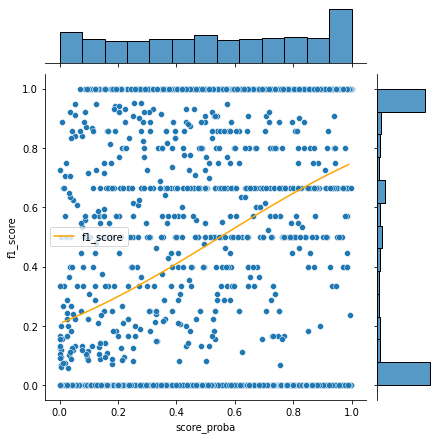

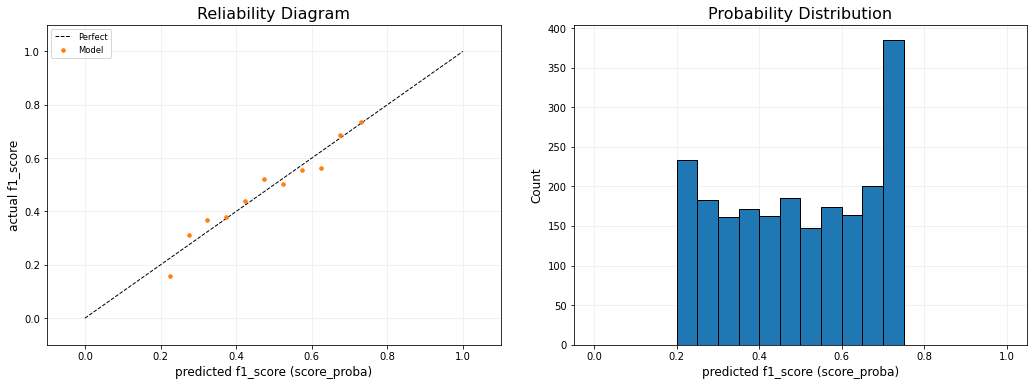

In [ ]:
from functools import partial
from logistic import LogisticRegression
from utils_generic import method_name, generate_uuid


model_classpath = LogisticRegression
model_hyperparams = {}

# -------------------------------------------------------------------
#
# Fit LOGISTIC REGRESSION
# 
# -------------------------------------------------------------------
fit_logistic = partial(
    fit_model,
    model_classpath=model_classpath,
    model_hyperparams=model_hyperparams,
    target=CALIBRATION_TARGET,
)

results_metadata = {}
results_model = {}
results_preds = {}
for col in UNCALIBRATED_SCORE_COLS:
    features = sorted([col])
    
    calibrator_metadata = {
        "dataset_name": NORMALIZED_DATASET_NAME,
        "split_name": SPLIT_NAME,
        "preds_train_path": TRAIN_SET_PREDS_FILEPATH,
        "evals_train_path": TRAIN_SET_EVALS_FILEPATH,
        "model_classpath": method_name(model_classpath),
        "model_hyperparameters": model_hyperparams,
        "features": features,
        "features_uuid": generate_uuid(features),
        "target_metric": CALIBRATION_TARGET,
    }
    
    calibrator_uuid = generate_uuid(calibrator_metadata)
    calibrator_metadata["calibrator_uuid"] = calibrator_uuid
    
    name = f"logistic_mse_train_{col}_{CALIBRATION_TARGET}_{calibrator_uuid}"
    calibrator_metadata["name"] = name
    
    calibrator_figname = f"{CALIB_ROOT_DIR}/{name}"
    calibrator_metadata["calibrator_figname"] = calibrator_figname
    # Uncalibrated and calibrated values
    X = X_train[features].values.flatten()
    y = y_train.values.copy().flatten()
    
    # We re-use the same structure as the preds we've loaded initially
    # write them into a calibrated predictions file.
    model, preds = fit_logistic(X=X, y=y, col=col, figname=calibrator_figname)
    
    results_model[col] = model
    results_preds[col] = preds
    results_metadata[col] = calibrator_metadata

#### Store model and calibrated predictions

In [ ]:
from utils_generic import generate_uuid

import joblib
import yaml
import os


def store_calibration_results(parent_dir, data, preds: dict, models: dict, metadata: dict):
    preds_ext = ".csv.gz"
    model_ext = ".joblib"
    metadata_ext = "metadata.yaml"
    
    os.makedirs(f"{parent_dir}/preds", exist_ok=True)
    os.makedirs(f"{parent_dir}/models", exist_ok=True)
    
    keys = preds.keys()
    for key in keys:
        pred_key = preds[key]
        model_key = models[key]
        metadata_key = metadata[key]
        
        d = data.copy()
        d[key] = pred_key
        
        key_name = metadata_key["name"]
        preds_filepath = f"{parent_dir}/preds/{key_name}{preds_ext}"
        print("\nStoring predictions for", key_name, "with columns:", d.columns, "at", preds_filepath)
        d.to_csv(preds_filepath)
        
        model_filepath = f"{parent_dir}/models/{key_name}"
        print("\nStoring model pickle and meatadata for", key_name, "at", model_filepath)
        joblib.dump(model_key, model_filepath + model_ext)

        with open(model_filepath + metadata_ext, "w") as f:
            yaml.dump(metadata_key, f)
            
            
# Sanity check
store_calibration_results(
    CALIB_ROOT_DIR,
    data=pd.DataFrame(y_train),
    preds=results_preds,
    models=results_model,
    metadata=results_metadata,
 )

## Compute `Evals` in training


In [ ]:
CALIB_EVALS_DIR = f"{CALIB_ROOT_DIR}/evals"
os.makedirs(CALIB_EVALS_DIR, exist_ok=True)


# Metrics to compute
CORR_METRICS_SUFFIX = "correlation_metrics"
CALIB_METRICS_SUFFIX = "calibration_metrics"
# ---------------------------------------------------------------------------------------------------
# 
# These files will contain the metrics concerning the different calibration techniques applied!
# 
# ---------------------------------------------------------------------------------------------------
# Name of the filepath to output the correlation metrics to
CALIBRATOR_TRAIN_CORR_METRICS = f"{CALIB_EVALS_DIR}/train_{BASE_FILENAME}_{CORR_METRICS_SUFFIX}.csv"

# Name of the filepath to output the calibration metrics to
CALIBRATOR_TRAIN_CALIB_METRICS = f"{CALIB_EVALS_DIR}/train_{BASE_FILENAME}_{CALIB_METRICS_SUFFIX}.csv"

!ls {CALIB_EVALS_DIR}


Just for a quick sanity check, the predicted distribution should be closer to the target metric `CALIBRATION_TARGET`, especially around the mean, since we're using the MSE (and the predictive mean is known to be the minimizer of the MSE).

- We note that the true distribution (`y_train`) has higher variance.
- Regardless of normalization scores, every distribution approximates the `mean`.
- None of these distributions is able to model values all way up to 1, i.e., maximum prediction is always below 1 (how will this affect user's confidence?, how is it compared with the OOD results?)

In [ ]:
calibration_preds_df = pd.DataFrame(results_preds)
#calibration_preds_df[CALIBRATION_TARGET] = y_train.values
calibration_preds_df.index = X_train.index
pd.concat((calibration_preds_df, y_train), axis=1, names=list(calibration_preds_df.columns) + [CALIBRATION_TARGET]).describe()

In [ ]:
# Calibration training evals (the metrics file used to retrieve the CALIBRATION_TARGET)
TRAIN_EVALS = pd.read_csv(TRAIN_SET_EVALS_FILEPATH).set_index(ID_COLS)
TRAIN_EVALS.tail()

In [ ]:
SCORE_COLS = UNCALIBRATED_SCORE_COLS
evals = TRAIN_EVALS

# This cell is copied from the notebook 4
import metrics as m

# Validation of the scores range
for col in SCORE_COLS:
    assert 0 <= min(calibration_preds_df[col]), f"{col} col is less than 0"
    assert max(calibration_preds_df[col]) <= 1, f"{col} col is greater than 1"

# Let us compute the
GLOBAL_METRICS = evals.join(calibration_preds_df, how="left")
GLOBAL_METRICS.head()

In [ ]:
REFERENCE_METRICS = [CALIBRATION_TARGET] 

# -----------------------------------------------------------------
GLOBAL_METRICS = GLOBAL_METRICS.reset_index()
print("Before de-duplication of data:", len(GLOBAL_METRICS))

_temp = GLOBAL_METRICS.sort_values(REFERENCE_METRICS, ascending=False)
GLOBAL_METRICS_UNIQUE = GLOBAL_METRICS[~_temp.duplicated(UNIQUE_ID_COL)].set_index(ID_COLS)

print("After de-duplication of data:", len(GLOBAL_METRICS_UNIQUE))
# -----------------------------------------------------------------
GLOBAL_METRICS_UNIQUE.info()

### Correlation metrics

In [ ]:
corr_metrics = []
for score_col in SCORE_COLS:
    score_col_results = m.CorrelationMetric(score_col).compute(GLOBAL_METRICS_UNIQUE, REFERENCE_METRICS)
    score_col_results = score_col_results.dropna()
    corr_metrics.append(score_col_results)
    
corr_metrics = pd.concat(corr_metrics, axis=0).reset_index(drop=True)
corr_metrics

In [ ]:
print("Storing correlation metrics at", CALIBRATOR_TRAIN_CORR_METRICS)
corr_metrics.to_csv(f"{CALIBRATOR_TRAIN_CORR_METRICS}", index=False)

### Calibration metrics


Amongst the calibration metrics, we have `expected calibration error (ECE)`, `brier score`, `AUC` which quantify the absolute and relative calibrations measures. 


In [ ]:
CALIB_METRICS = [CALIBRATION_TARGET]

In [ ]:
calib_metrics = []
for calib_metric in CALIB_METRICS:
    calib_results = m.CalibrationMetrics(calib_metric).compute(GLOBAL_METRICS_UNIQUE, SCORE_COLS)
    calib_results = calib_results.dropna()
    
    calib_metrics.append(calib_results)
    
calib_metrics = pd.concat(calib_metrics, axis=0)
calib_metrics

In [ ]:
print("Storing calibration metrics at", CALIBRATOR_TRAIN_CALIB_METRICS)
calib_metrics.describe().to_csv(CALIBRATOR_TRAIN_CALIB_METRICS, index=False)